## Custom Distributions

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

One of the main implementation details of pomegranate is that it decouples the mathematics behind the various models from the likelihood functions that are used in them. For example, the class probabilities calculated for mixture models and Bayes' classifiers involve multiplying a likelihood function and a prior probability. Typically, this likelihood function is assumed to be Gaussian, but there is no algorithmic requirement that it be any specific probability distribution. This is why pomegranate is much more flexible than other packages in terms of the types of distributions that various models can be built using.

However, a major limitation in pomegranate for a long time was that while users were free to use any of the built in distributions to build models, they could not define their own in Python. The reason behind this is the Cython backend, which essentially required that the distributions be implemented in Cython.

Fortunatly, a recent patch has allowed users to define their own custom distributions. This means that users can define their own distributions, entirely in Python, and plug them in to existing models without modification. This tutorial will show you how to do that.

In [1]:
%matplotlib inline
import time
import pandas
import random
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import itertools

from pomegranate import *

random.seed(0)
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Feb 15 2019 

numpy 1.15.1
scipy 1.1.0
pomegranate 0.10.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


### Building a new normal distribution

Let's start off by building a custom normal distribution. Our goal is to build a pure Python object that has the exact same functionality as the normal distribution that is currently implemented, to demonstrate that the internals are all working correctly.

In [2]:
import scipy.stats

class NormalDistribution2():
    def __init__(self, mu, std):
        self.mu = mu
        self.std = std
        self.parameters = (self.mu, self.std)
        self.d = 1
        self.summaries = numpy.zeros(3)

    def log_probability(self, X):
        return scipy.stats.norm.logpdf(X, self.mu, self.std)

    def summarize(self, X, w=None):
        if w is None:
            w = numpy.ones(X.shape[0])

        X = X.reshape(X.shape[0])
        self.summaries[0] += w.sum()
        self.summaries[1] += X.dot(w)
        self.summaries[2] += (X ** 2.).dot(w)

    def from_summaries(self, inertia=0.0):
        self.mu = self.summaries[1] / self.summaries[0]
        self.std = self.summaries[2] / self.summaries[0] - self.summaries[1] ** 2 / (self.summaries[0] ** 2)
        self.std = numpy.sqrt(self.std)
        self.parameters = (self.mu, self.std)
        self.clear_summaries()

    def clear_summaries(self, inertia=0.0):
        self.summaries = numpy.zeros(3)

    @classmethod
    def from_samples(cls, X, weights=None):
        d = NormalDistribution2(0, 0)
        d.summarize(X, weights)
        d.from_summaries()
        return d

    @classmethod
    def blank(cls):
        return NormalDistribution2(0, 0)

The custom objects have a few requirements.

(1) An attribute, `d`, that stores the number of dimensions represented by the distribution. For univariate distributions like this normal distribution, this should just be 1.


(2) A method, `log_probability(X)`, that takes in a vector of shape (n_samples,) or a matrix of shape (n_samples, d) if multivariate, and returns the log probability of each sample. In this case we're just using the built-in scipy function for calculating log probabilities under a normal distribution for simplicity.

(3) A method, `summarize(X, weights=None)`, that takes in a vector of shape (n_samples,) or a matrix of shape (n_samples, d) if multivariate, calculates the sufficient statistics of that batch, and adds them to the growing sufficient statistics. In the case of a normal distribution, our sufficient statistics are the sum of the weights, the sum of the weighted points, and the sum of the weighted points squared. 

(4) A method, `from_summaries(inertia=0.0)`, that takes uses the stored sufficient statistics in order to update the model parameters. This should also clear the stored sufficient statistics for the next iteration of training.

(5) A method, `clear_summaries()`, that clears the stored sufficient statistics. Here, all we're doing is resetting the three stored summaries to 0.

(6) A class method, `from_samples(X, weights=None)` that rreturns a distribution that has been fit to the data. Generally this will initialize a dummy distribution and then overwrite the initial parameters using those derived from the data.

(7) A class method, `blank()` or `blank(d)` if multivariate, that creates a dummy distribution with the appropriate number of parameters. Here we return a distribution with a mean and a variance of 0. These dummies generally aren't meant to be used.

Let's test this against the built in distributions!

In [3]:
NormalDistribution(2.532, 8.211).log_probability(102.563), NormalDistribution2(2.532, 8.211).log_probability(102.563)

(-77.23179709134088, -77.23179709134129)

Looks good so far. Looks like there might be a small difference at very smalll precisions.

In [4]:
X = numpy.random.normal(0.872, 0.57721, size=100000)

print NormalDistribution.from_samples(X).parameters
print NormalDistribution2.from_samples(X).parameters

[0.8729100873003006, 0.5756744412108401]
(0.8729100873002944, 0.5756744412108432)


Great! Now let's try putting this into a more complex model.

In [5]:
X = numpy.random.normal(0, 1, size=(1000, 1))
X[::2] += 1

model1 = GeneralMixtureModel.from_samples(NormalDistribution, 2, X, max_iterations=5, init='first-k', verbose=True)

[1] Improvement: 27.2627736077	Time (s): 0.0001581
[2] Improvement: 8.07298439798	Time (s): 0.000766
[3] Improvement: 3.62961826446	Time (s): 0.0003512
[4] Improvement: 1.98797485885	Time (s): 0.0002301
[5] Improvement: 1.2248102842	Time (s): 0.0002499
Total Improvement: 42.1781614132
Total Time (s): 0.0024


In [6]:
model2 = GeneralMixtureModel.from_samples(NormalDistribution2, 2, X, max_iterations=5, init='first-k', verbose=True)

[1] Improvement: 27.2627736077	Time (s): 0.000731
[2] Improvement: 8.07298439797	Time (s): 0.0005782
[3] Improvement: 3.62961826446	Time (s): 0.001271
[4] Improvement: 1.98797485886	Time (s): 0.000777
[5] Improvement: 1.2248102842	Time (s): 0.0008059
Total Improvement: 42.1781614132
Total Time (s): 0.0053


In [7]:
model1.log_probability(X).sum(), model2.log_probability(X).sum()

(-1528.71286897159, -1528.712868971989)

Great! It looks like both for fitting a mixture model and performing inference that our new Python distribution is identical to the built-in one. Now, how much slower is it to use the Python object versus the Cython one?

In [8]:
X = numpy.random.normal(0, 1, size=(300000, 1))
X[::2] += 1

%timeit GeneralMixtureModel.from_samples(NormalDistribution, 2, X, max_iterations=100, init='first-k')
%timeit GeneralMixtureModel.from_samples(NormalDistribution2, 2, X, max_iterations=100, init='first-k')

1 loop, best of 3: 1.91 s per loop
1 loop, best of 3: 6.2 s per loop


It looks like it can be a fair bit slower. Another drawback of using a Python distibution is that it may be less efficient to do multi-threaded parallelism, because the Python object requires the GIL. However, many numpy operations will drop the GIL and so can actually be used with multi-threading, but that isn't guaranteed.

In [9]:
%timeit GeneralMixtureModel.from_samples(NormalDistribution, 2, X, max_iterations=100, init='first-k', n_jobs=2)
%timeit GeneralMixtureModel.from_samples(NormalDistribution2, 2, X, max_iterations=100, init='first-k', n_jobs=2)

1 loop, best of 3: 1.26 s per loop
1 loop, best of 3: 5.24 s per loop


This distribution acts exactly like any other distribution. If we want to use a different distribution to model different features, we can use a mix of custom and built-in distrbutions with ease.

In [10]:
X = numpy.random.normal(0, 1, size=(500, 3))
X[::2] += 1
X[:,1] = numpy.abs(X[:,1])

distributions = [NormalDistribution, ExponentialDistribution, NormalDistribution2]
model = GeneralMixtureModel.from_samples(distributions, 2, X, verbose=True)

[1] Improvement: 23.3118792386	Time (s): 0.05893
[2] Improvement: 6.6995292814	Time (s): 0.05847
[3] Improvement: 3.02105540912	Time (s): 0.06
[4] Improvement: 1.70279214016	Time (s): 0.06304
[5] Improvement: 1.09909719263	Time (s): 0.05982
[6] Improvement: 0.779310017847	Time (s): 0.05784
[7] Improvement: 0.591259664419	Time (s): 0.06187
[8] Improvement: 0.46875233889	Time (s): 0.05902
[9] Improvement: 0.379690162552	Time (s): 0.06065
[10] Improvement: 0.308612888606	Time (s): 0.06025
[11] Improvement: 0.248853999906	Time (s): 0.06143
[12] Improvement: 0.198045431575	Time (s): 0.06006
[13] Improvement: 0.155459449172	Time (s): 0.06121
[14] Improvement: 0.120656432783	Time (s): 0.06043
[15] Improvement: 0.0929877467668	Time (s): 0.0612
Total Improvement: 39.1779813944
Total Time (s): 0.9650


### Building a new distribution, the Student T Distribution

There have been a few requests to add in the Student T distribution to pomegranate. This is, essentially, a version of the normal distribution that has a heavy tail to reduce the effect of outliers on the model. Now, instead of waiting for me to find time to add it, you can add it in yourself! Here is an example of what a custom student T distribution might look like.

In [11]:
class StudentTDistribution():
    def __init__(self, mu, std, df=1.0):
        self.mu = mu
        self.std = std
        self.df = df
        self.parameters = (self.mu, self.std)
        self.d = 1
        self.summaries = numpy.zeros(3)

    def probability(self, X):
        return numpy.exp(self.log_probability(X))
        
    def log_probability(self, X):
        return scipy.stats.t.logpdf(X, self.df, self.mu, self.std)

    def summarize(self, X, w=None):
        if w is None:
            w = numpy.ones(X.shape[0])

        X = X.reshape(X.shape[0])
        self.summaries[0] += w.sum()
        self.summaries[1] += X.dot(w)
        self.summaries[2] += (X ** 2.).dot(w)

    def from_summaries(self, inertia=0.0):
        self.mu = self.summaries[1] / self.summaries[0]
        self.std = self.summaries[2] / self.summaries[0] - self.summaries[1] ** 2 / (self.summaries[0] ** 2)
        self.std = numpy.sqrt(self.std)
        self.parameters = (self.mu, self.std)
        self.clear_summaries()

    def clear_summaries(self, inertia=0.0):
        self.summaries = numpy.zeros(3)

    @classmethod
    def from_samples(cls, X, weights=None, df=1):
        d = StudentTDistribution(0, 0, df)
        d.summarize(X, weights)
        d.from_summaries()
        return d

    @classmethod
    def blank(cls):
        return StudentTDistribution(0, 0)

The primary difference between the Student T distribution and the normal distribution is the degree of freedom parameter that has to be set in advance---it is not meant to be learned from the data. The higher this parameter, the more like a normal distribution it is.

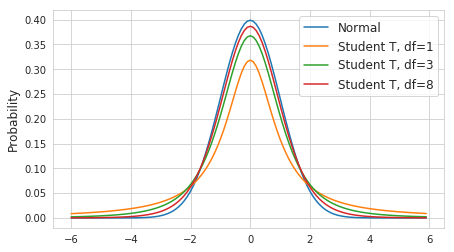

In [12]:
dn = NormalDistribution(0, 1)
dt1 = StudentTDistribution(0, 1, 1)
dt3 = StudentTDistribution(0, 1, 3)
dt8 = StudentTDistribution(0, 1, 8)

x = numpy.arange(-6, 6, 0.1)

plt.figure(figsize=(7, 4))
plt.plot(x, dn.probability(x), label="Normal")
plt.plot(x, dt1.probability(x), label="Student T, df=1")
plt.plot(x, dt3.probability(x), label="Student T, df=3")
plt.plot(x, dt8.probability(x), label="Student T, df=8")
plt.ylabel("Probability", fontsize=12)
plt.legend(fontsize=12)
plt.show()

Let's stick it in a mixture model now and see what the normal and the Student T versions look like.

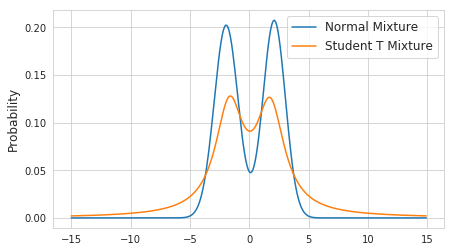

In [13]:
X = numpy.random.normal(-2, 1, size=(1000, 1))
X[::2] += 4

modeln = GeneralMixtureModel.from_samples(NormalDistribution, 2, X)
modelt = GeneralMixtureModel.from_samples(StudentTDistribution, 2, X)

x = numpy.arange(-15, 15, 0.1)

plt.figure(figsize=(7, 4))
plt.plot(x, modeln.probability(x), label="Normal Mixture")
plt.plot(x, modelt.probability(x), label="Student T Mixture")
plt.ylabel("Probability", fontsize=12)
plt.legend(fontsize=12)
plt.show()

The results look reasonable. The Student T distributions have a smaller valley separating the peaks because they have heavier tails. Additionally, the peaks are closer together for the Student T distribution because the heavier tails assign more credit from points in one cluster to the distribution modeling the other cluster. This pulls the centers together slightly.

### Block Distributions

Currently, pomegranate supports distributions where the features are either independent, through `IndependentComponentsDistribution`, or have a Gaussian covariance structure, as in `MultivariateGaussianDistribution`. However, sometimes one would want to model their features in blocks, where the covariance amongst features in the block are accounted for. When all your variables are Gaussian, this is simply having an enforced block structure on your covariance matrix. In the more general case, this can take the form of a Bayesian network. 

This new custom support allows us to do that easily. 

In [14]:
class BlockGaussianDistribution():
    def __init__(self, distributions):
        self.distributions = distributions
        self.d = sum([d.d for d in distributions])
        
    def log_probability(self, X):
        i, log_probability = 0, numpy.zeros(X.shape[0])
        for distribution in self.distributions:
            log_probability += distribution.log_probability(X[:, i:i+distribution.d].copy())
            i += distribution.d
        return log_probability
    
    def summarize(self, X, w=None):
        i = 0
        for distribution in self.distributions:
            distribution.summarize(X[:, i:i+distribution.d].copy(), w)
            i += distribution.d
    
    def from_summaries(self, inertia=0.0):
        for distribution in self.distributions:
            distribution.from_summaries(inertia)

    @classmethod
    def from_samples(cls, X, weights=None, ds=[]):
        distributions = [MultivariateGaussianDistribution.blank(d) for d in ds]
        d = BlockGaussianDistribution(distributions)
        d.summarize(X, weights)
        d.from_summaries()
        return d

    @classmethod
    def blank(cls, ds):
        distributions = [MultivariateGaussianDistribution.blank(d) for d in ds]
        return BlockGaussianDistribution(distributions)

In the code above, `BlockGaussianDistribution` creates multiple `MultivariateGaussianDistribution` objects, each modeling a different set of features. The probability of an example is then the product of the probability of each set of features under their respective distribution.

To evaluate this, let's look at the diabetes data set. This is normally a regression task, so we'll have to binarize the response using the median value. Additionally, the data has been scaled for us already, so we'll have to go ahead an unscale it for the purposes of our demonstration.

In [15]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

from pomegranate import LogNormalDistribution, BernoulliDistribution, NormalDistribution

data = load_diabetes()
X, y = data.data, data.target
X[:,1] = (X[:,1] - X[:,1].min()) / (X[:,1].max() - X[:,1].min())
X[:,0] -= X[:,0].min() - 0.001
X[:,2] -= X[:,2].min() - 0.001
X[:,3] -= X[:,3].min() - 0.001
y = y > numpy.median(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

The first four variables correspond to age, sex, BMI, and average blood pressure. The remaining six features are different blood serum measurements. In this example, let's use univariate distributions to model the first four variables, and a multivariate Gaussian with a full covariance matrix to model the last six.

To get a sense for what distributions might be a good fit for the first four features, we can visualize the training data.

/home/jmschr/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jmschr/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jmschr/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/jmschr/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


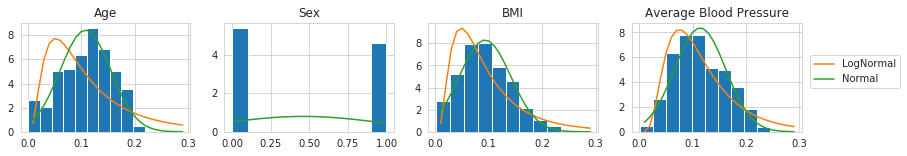

In [16]:
import matplotlib.pyplot as plt

names = 'Age', 'Sex', 'BMI', 'Average Blood Pressure'
plt.figure(figsize=(14, 2))

for i in range(4):
    plt.subplot(1, 4, i+1)
    
    x = numpy.arange(0.01, 0.3 if i != 1 else 1, 0.01)
    
    plt.hist(X_train[:,i], bins=10, normed=True)
    plt.plot(x, LogNormalDistribution.from_samples(X_train[:,i]).probability(x), label="LogNormal")
    plt.plot(x, NormalDistribution.from_samples(X_train[:,i]).probability(x), label="Normal")
    plt.title(names[i], fontsize=12)
    
plt.legend(loc=(1.05, 0.4))
plt.show()

It looks like age and BMI may be better modeled by a normal distribution than a log normal distribution, but that average blood pressure is better modeled with a log normal distribution. Due to the binary nature of sex in this data set, a Bernoulli distribution seems like the right choice.

Let's now train a Bayes' classifier using our custom block distribution! To evaluate its performance, let's compare against a model that simply uses a single multivariate Gaussian distribution per class.

In [17]:
ds = [BlockGaussianDistribution([NormalDistribution.blank(),
                                 BernoulliDistribution.blank(),
                                 NormalDistribution.blank(),
                                 LogNormalDistribution.blank(),
                                 MultivariateGaussianDistribution.blank(6)]) for j in range(2)]
model = BayesClassifier(ds)
model.fit(X_train, y_train)

model2 = BayesClassifier.from_samples(MultivariateGaussianDistribution, X_train, y_train)

model.score(X_test, y_test), model2.score(X_test, y_test)

(0.7303370786516854, 0.6966292134831461)

It looks like the custom distribution can outperform the simpler, full covariance Gaussian, in this setting.